##### Laboratoire 2
# Discrimination linéaire et réseaux de neurones profonds
## Classification et régression (Datasets FER et FG-NET)

### GTI771 - Apprentissage machine avancé
#### Département de génie logiciel et des technologies de l’information (LogTI)

##### <font color=white> Version 1.0 - février 2020<br>Version 2.0 - février 2020 <br> Version 3.0 - mars 2020<br>Version 4.0 - juin 2020 (Richard Rail)<br>Version 4.1 - février 2021<br></font><br>Version 4.2 - février 2022<br>


##### Prof. Alessandro L. Koerich

| Étudiants             | Antoine Brassard Lahey - BRAA05089904 <br/>  Antoine Pelchat-Fortin - PELA04029703 <br/> Sébastien Charbonneau - CHAS01049805               |
|-----------------------|---------------------------------------------------------|
| Session               | ÉTÉ 2022                                                |
| Équipe                | 10                                                      |
| Numéro du laboratoire | 2                                                       |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Lucas Geffard                                           |
| Date                  | 2022-07-12                                              |

# Introduction

Ce deuxième laboratoire porte sur l'utilisation de trois algorithmes d'apprentissage soit les algorithmes de régression, les réseaux neuronaux et les réseaux neuronaux profonds. Dans ce laboratoire, vous êtes amenés à utiliser de nouvelles approches à l’aide de ces algorithmes aﬁn de résoudre deux problèmes: prédiction de l'âge de personnes à partir de photos du visage (régression); problème de classiﬁcation des expressions faciales (FER) introduit dans le cadre du premier laboratoire de ce cours.

Le problème de régression qui vous est présenté est le problème [Facial Aging Estimation (FAE)](https://yanweifu.github.io/FG_NET_data/index.html), dont le but est de prédire l'âge des personnes à partir du visage. En vous basant sur les concepts vus en classe et l'expérience acquise dans le laboratoire 1, vous êtes invité à reprendre les primitives développées lors du laboratoire 1 ou d'autres primitives que vous jugez pertinentes à extraire sur ces types d’images et effectuer l’extraction de celles-ci sur l’ensemble de données fournies avec cet énoncé. 

##### Description de l'ensemble de données:
* 1002 images faciales de 82 sujets multiraciaux âgés de 0 à 69 ans;
* Déséquilibré: 50% des sujets ont entre 0 et 13 ans;
* Images couleur et niveaux de gris avec une dimension moyenne de 384x487 pixels, et la résolution varie de 200 dpi à 1200 dpi;
* Grande variation d'éclairage, de pose, d'expression faciale, de flou et d'occlusions (par exemple, moustache, barbe, lunettes, etc.).

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données FG-NET:

![Exemples de FER](https://www.mdpi.com/sensors/sensors-16-00994/article_deploy/html/images/sensors-16-00994-g001.png)

Veuillez noter que les images qui vous sont fournies ne sont pas nécessairement similaires aux images de FER. Plusieurs images comportent du bruit, des artéfacts ou des éléments non pertinents. Le défi de ce laboratoire repose sur cette difficulté qui est chose courante dans des problèmes d’apprentissage machine moderne.

Tout comme le premier travail pratique, vous réaliserez ce deuxième laboratoire avec la technologie Python3 conjointement avec la librairie d’apprentissage machine scikit-learn et TensorFlow et Keras pour la partie réseaux de neurones. Vous êtes invité à reprendre le code développé lors du laboratoire 1 afin de continuer son développement.

<font color=black> L’évaluation de ce laboratoire sera basée sur la qualité des modèles entraînés, la comparaison des performances réalisées par les différents modèles, les réponses aux questions dans cette notebook ainsi que l'organisation de votre code source (SVP, n'oubliez pas des commentaires dans le code!).</font>

* #### Partie 1: Régression
* Régression lineaire
* Régression Ridge
* Régression Lasso et Elastic-Net
* Descente du gradiente stochastique (SGD)<br>
<br>
* #### Partie 2: Classification
* Régression logistique
* Réseaux de neurones MLP <br>
<br>
* #### Partie 3: Classification et régression
* Réseaux convolutionel entraîné "from scratch"
* Réseaux convolutionel + modèles pre-entraînes (transfer learning)
* Réseaux convolutionel adapté à la régression

## Partie 0: Imports

#### (0a) Import de bibliotèques



##### À faire:
1. Ajouter toutes les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [1]:
# Numpy - Used to manipulate matrices
import numpy as np

# Matplotlib - 2D plotting library
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

# Library to extract features from images. Used for LBP
import skimage
from skimage import feature
from skimage.restoration import denoise_tv_chambolle

# SKLearn - Implementations of different machine learning models, used for tuning as well
import absl
import sklearn
import sklearn.metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG19, InceptionResNetV2, EfficientNetV2L
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Dropout, MaxPooling2D, Flatten, RandomFlip, RandomContrast, RandomHeight, Resizing, RandomRotation, RandomBrightness, RandomWidth, RandomZoom
from tensorflow.keras.utils import to_categorical

# OpenCV - Includes functions for computervision. Used for image preprocessing and SIFT implementation.
import cv2

# Used to get float maxvalue
import sys

# Used for file system operations
import os

# Used to write csv datasets
import csv

# Used to manipulate tabular data (dataframes)
import pandas

# Used to save models
import pickle as pkl
import matplotlib.patches as patches

import tensorflow as tf
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#### (0b) Fonctions

##### À faire:
Avez-vous créé des fonctions? Si oui, vous devez les mettre ici, avec une description.

In [72]:
def read_FER_csv(input_path, feature_length):
  data = np.loadtxt(input_path, delimiter=',', dtype=str )
  (Xtrain, ytrain) = split_FER_csv(data, 1, 28710, feature_length)
  (Xtest, ytest) = split_FER_csv(data, 28710, 32299, feature_length)
  (Xval, yval) = split_FER_csv(data, 32299, 35888, feature_length)
  return Xtrain, ytrain, Xtest, ytest, Xval, yval

def split_FER_csv(data, start_index, end_index, feature_length):
  X = np.ones((end_index - start_index, feature_length), float)
  
  for i in range(start_index, end_index):
    X[i-start_index] = data[i,1].split(" ")

  y = data[start_index:end_index, 0].astype(int)

  return (X, y)

def eval_model(model, x_train, y_train, x_val, y_val, x_test, y_test, titre):
  # Classification
  ypred_train = model.predict(x_train)
  if not(isinstance(ypred_train[0], np.int32) or isinstance(ypred_train[0], np.int64)):
    ypred_train = np.argmax(ypred_train, axis=1)
        
  training_accuracy = sklearn.metrics.accuracy_score(y_train, ypred_train, normalize=True, sample_weight=None)
  print("Training accuracy: ")
  print(str(training_accuracy * 100) + '%')
  print("Training error: ")
  print(str((1 - training_accuracy) * 100) + '%')

  ypred_val = model.predict(x_val)
  if not(isinstance(ypred_val[0], np.int32) or isinstance(ypred_val[0], np.int64)):
    ypred_val = np.argmax(ypred_val, axis=1)
    
  validation_accuracy = sklearn.metrics.accuracy_score(y_val, ypred_val, normalize=True, sample_weight=None)
  print("Validation accuracy: ")
  print(str(validation_accuracy * 100) + '%')
  print("Validation error: ")
  print(str((1 - validation_accuracy) * 100) + '%')


  ypred_test = model.predict(x_test)
  if not(isinstance(ypred_test[0], np.int32) or isinstance(ypred_test[0], np.int64)):
    ypred_test = np.argmax(ypred_test, axis=1)
    
  test_accuracy = sklearn.metrics.accuracy_score(y_test, ypred_test, normalize=True, sample_weight=None)
  print("Test accuracy: ")
  print(str(test_accuracy * 100) + '%')
  print("Test error: ")
  print(str((1 - test_accuracy) * 100) + '%')

  train_precision = sklearn.metrics.precision_score(y_train, ypred_train, average='micro')
  validation_precision = sklearn.metrics.precision_score(y_val, ypred_val, average='micro')
  test_precision = sklearn.metrics.precision_score(y_test, ypred_test, average='micro')
  avg_precision = (train_precision + validation_precision + test_precision) / 3
  print("Average precision: " + str(avg_precision * 100) + '%')

  # Confusion matrix
  matrice_confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=ypred_test, labels=[i for i in range(0, len(labels))])
  disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=matrice_confusion, display_labels=labels)
  disp.plot()
  plt.title(f'Matrice de confusion - {titre}')
  plt.show()

def eval_regression_model(model, x_train, y_train, x_val, y_val, x_test, y_test, titre):
  # Classification
  ypred_train = model.predict(x_train)
  if not(isinstance(ypred_train[0], np.int32) or isinstance(ypred_train[0], np.int64)):
    ypred_train = np.argmax(ypred_train, axis=1)

  ypred_val = model.predict(x_val)
  if not(isinstance(ypred_val[0], np.int32) or isinstance(ypred_val[0], np.int64)):
    ypred_val = np.argmax(ypred_val, axis=1)

  ypred_test = model.predict(x_test)
  if not(isinstance(ypred_test[0], np.int32) or isinstance(ypred_test[0], np.int64)):
    ypred_test = np.argmax(ypred_test, axis=1)

  mae_train = sklearn.metrics.mean_absolute_error(y_train, ypred_train)
  mse_train = sklearn.metrics.mean_squared_error(y_train, ypred_train)
  r2_train = sklearn.metrics.r2_score(y_train, ypred_train)

  mae_val = sklearn.metrics.mean_absolute_error(y_val, ypred_val)
  mse_val = sklearn.metrics.mean_squared_error(y_val, ypred_val)
  r2_val = sklearn.metrics.r2_score(y_val, ypred_val)

  mae_test = sklearn.metrics.mean_absolute_error(y_test, ypred_test)
  mse_test = sklearn.metrics.mean_squared_error(y_test, ypred_test)
  r2_test = sklearn.metrics.r2_score(y_test, ypred_test)

  print('Training Set')
  print(f'MAE: {mae_train}')
  print(f'MSE: {mse_train}')
  print(f'R2: {r2_train}')
  
  print('Validation Set')
  print(f'MAE: {mae_val}')
  print(f'MSE: {mse_val}')
  print(f'R2: {r2_val}')
  
  print('Test Set')
  print(f'MAE: {mae_test}')
  print(f'MSE: {mse_test}')
  print(f'R2: {r2_test}')



def save_model(model, pkl_name):
    # Save model
    pickle = open(f'Models/{pkl_name}.pkl', 'wb') 
    pkl.dump(model, pickle)
    pickle.close()
    
def convert_to_rgb(Xtrain, Xval, Xtest, width, length):
    Xtrain_rgb = np.zeros((Xtrain.shape[0], width, length, 3))
    Xval_rgb = np.zeros((Xval.shape[0], width, length, 3))
    Xtest_rgb = np.zeros((Xtest.shape[0], width, length, 3))
    
    for i, image in enumerate(Xtrain):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xtrain_rgb[i] = to_rgb
        
    for i, image in enumerate(Xval):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xval_rgb[i] = to_rgb
        
    for i, image in enumerate(Xtest):
        to_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        Xtest_rgb[i] = to_rgb
        
    return Xtrain_rgb, Xval_rgb, Xtest_rgb

def convert_grayscale_to_3_channels(Xtrain, Xval, Xtest, width, length):
    Xtrain_stacked_grayscale = np.zeros((Xtrain.shape[0], width, length, 3))
    Xval_stacked_grayscale = np.zeros((Xval.shape[0], width, length, 3))
    Xtest_stacked_grayscale = np.zeros((Xtest.shape[0], width, length, 3))
    
    for i, image in enumerate(Xtrain):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xtrain_stacked_grayscale[i] = stacked_img
    
    for i, image in enumerate(Xval):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xval_stacked_grayscale[i] = stacked_img
        
    for i, image in enumerate(Xtest):
        stacked_img = np.concatenate((image,)*3, axis=-1)
        Xtest_stacked_grayscale[i] = stacked_img
        
    return Xtrain_stacked_grayscale, Xval_stacked_grayscale, Xtest_stacked_grayscale

def transfer_train(pre_trained_model, Xtrain, ytrain, Xval, yval):
  for layer in pre_trained_model.layers:
      layer.trainable = False

  transfer_trained_model = Sequential()
  transfer_trained_model.add(pre_trained_model)

  # On ajoute les couches pour la classification
  transfer_trained_model.add(Flatten())
  transfer_trained_model.add(Dense(100, activation='relu'))
  transfer_trained_model.add(Dense(len(labels), activation='softmax'))

  # Training avec images greyscale 3 channels (stacked)
  transfer_trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  transfer_trained_model.fit(Xtrain, ytrain, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval))
  return transfer_trained_model

def augment_data(X, y, shape):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  
  augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    Resizing(shape[0], shape[0])
  ])

  augmented = []
  for (augmented_image, _) in dataset.map(lambda x, y: (augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE):
    augmented.append(augmented_image.numpy())

  return np.array(augmented)

def create_my_cnn(input_shape, output_shape, output_activation):
  pixel_cnn = Sequential()
  pixel_cnn.add(Conv2D(16, (5, 5), padding='same', input_shape=input_shape, activation='relu'))
  pixel_cnn.add(AveragePooling2D((2, 2), strides=2))

  pixel_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  pixel_cnn.add(AveragePooling2D((2, 2), strides=2))

  pixel_cnn.add(Flatten()),
  pixel_cnn.add(Dense(120, activation='relu'))
  pixel_cnn.add(Dropout(0.3))
  pixel_cnn.add(Dense(84, activation='relu'))
  pixel_cnn.add(Dropout(0.3))
  pixel_cnn.add(Dense(output_shape, activation=output_activation))
  return pixel_cnn

def pretreat_fgnet(X):
  X_pretreated = []

  for image in X:
      image = image / np.max(image)
      image = skimage.restoration.denoise_tv_bregman(image)
      image = cv2.resize(image, (48, 48)).reshape((48, 48, 1))
      X_pretreated.append(image)
  
  return np.array(X_pretreated)

def print_regression_results(regressionName,regression_obj, y_pred, y_test):
    # The coefficients
    print("---  "+str(regressionName)+" ---\n")
    print("Coefficients: \n", regression_obj.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    print("--------------------------")

# Partie 1: Explorez les algorithmes de régression
## FG-NET dataset (Facial Aging Estimation)

Dans cette partie vous devez explorer les <b> algorithmes de régression linéaire </b> disponibles dans Scikit-learn, comme régression least square, régression Ridge, régression Lasso et Elastic-Net, descente du gradient stochastique (SGD), etc.

Vous devez comparer la performance de ces algorithmes pour l'ensemble de données FG-NET sur:

1. Le vecteur de pixels (images vectorisées)
2. Vecteur de primitives (reprendre l'algorithme d'extraction de primitives que vous avez utilisées dans le Laboratoire 1, p.ex. LBP). Vous pouvez reprendre les primitives "réduits" que vous avez utilisées dans le Laboratoire 1 (p.ex. vecteur LBP après PCA), si vous pensez qu’ils sont plus performants.

### 1a: Charger le fichier de données

In [65]:
# Load data
X_fgnet = np.loadtxt('Datasets/fgnet_256x256.csv', delimiter=',', dtype=int )
y_fgnet = np.loadtxt('Datasets/fgnet_labels.csv', delimiter=',', dtype=int )

X_fgnet = X_fgnet.reshape(X_fgnet.shape[0], 256, 256)

### 1b: Visualisation des visages

Vous pouvez visualiser les images en utilisant `plt.imshow`.

Il y a différents types de prétraitement que nous pouvons appliquer à des images dans les ensembles de données pour réduire la variabilité, réduire des bruits, etc.

Voici deux sources pour vous aidez à décider:
- http://eprints.qut.edu.au/92300/1/manuscript_Jhony.pdf
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7475805

### À faire:
1. Pensez-vous qu’est nécessaire un prétraitement des images? Si oui, vous pouvez choisir différents algorithmes de prétraitement dans [scikit-image](https://scikit-image.org/docs/stable/api/api.html). Il y a aussi autres types de prétraitement plus généraux dans [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing).
2. Expliquer et justifier les prétraitements choisis.

#### Code

In [66]:

X_fgnet = pretreat_fgnet(X_fgnet)

#### Résultats et réponses

In [ ]:
# Votre explication/justification

### 1c: Statistiques sur les sujets et étiquettes

##### À faire:
1. Calculer quelques statistiques (# images par sujet, distribution des âges, etc.) que vous jugez importantes sur les données
2. Faire une analyse des résultats et présenter vos conclusions basées sur ces statistiques.

#### Code:

Statistics of Trainning data


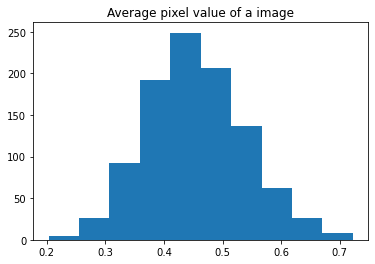

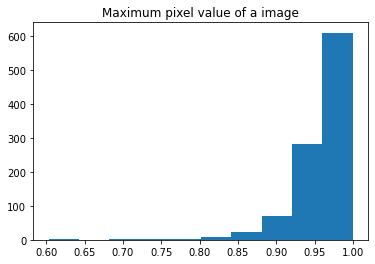

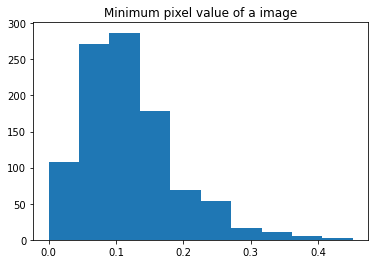

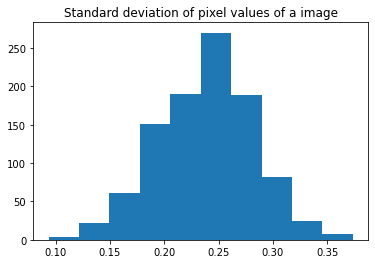

In [85]:
# Votre code ici
maxlist = []
minlist = []
averagelist = []
st_devlist = []
nb_images = 0;

for img in X_fgnet:
    img = img.reshape(2304)
#     print("--------")
#     print(img.shape)
#     print(img[nb_images].shape)
    averagelist.append(sum(img)/len(img))
    maxlist.append( np.max(img))
    minlist.append(np.min(img))
    st_devlist.append( np.std(img))
    
# print(averagelist) 
# print(averagelist[0])
# print(averagelist[2])
# print(averagelist[3])

# Code exemple:
# Histogramme des étiquettes (classes)
hist, _ = np.histogram(y_fgnet, density=False, bins=7, range=(0, 7))

print("Statistics of Trainning data")
plt.hist(averagelist)
plt.title('Average pixel value of a image')
plt.show()
plt.hist(maxlist)
plt.title('Maximum pixel value of a image')
plt.show()
plt.hist(minlist)
plt.title('Minimum pixel value of a image')
plt.show()
plt.hist(st_devlist)
plt.title('Standard deviation of pixel values of a image')
plt.show()
# Code exemple:
# Histogramme des étiquettes
#hist, _ = np.histogram(ytrain, density=False, bins=7, range=(0, 7))

#### Résultats et réponses:

In [ ]:
# Vos résultats ici:

# Code exemple:
# Code exemple
# Plot du histogramme
# import matplotlib.pyplot as plt

### 1d: Créer et évaluer des modèles de régression

##### À faire:
1. Choisir au moins trois (3) algorithmes de régression linéaire disponibles dans Scikit-learn (p.ex. régression least square, régression Ridge, régression Lasso, régression Elastic-Net, descente du gradient stochastique (SGD), etc.)
2. Entraîner et optimiser les paramètres des modèles si nécessaire. Utiliser le protocole <font color=blue> "Leave One Subject Out Cross-Validation" </font> (LOSO).
3. Faire une analyse des résultats et présenter vos conclusions sur les modèles de régression.

| Algorithme            | Paramètres    |  MSE  |  MAE  |
|-----------------------|---------------|-------|-------|
| Regr lineaire         | XXX.XX        |XXX.XX |XXX.XX |
| Regr Ridge            | alpha = 0.1   |123.34 | 10.45 |
| Regr Lasso            | XXX.XX        |XXX.XX |XXX.XX |
| Regr ElasticNet       | XXX.XX        |XXX.XX |XXX.XX |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |
| ...                   | XXX.XX        |XXX.XX |XXX.XX |

#### Code:

In [84]:

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import SGDClassifier

X_fgnet_regression = X_fgnet.reshape(1002, 2304)

x_train,x_test,y_train,y_test=train_test_split(X_fgnet_raw,y_fgnet,test_size=0.2)


# Least Squares regression

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

print_regression_results("Linear Regression",regr,y_pred,y_test)

#regression Lasso

reg = linear_model.Lasso(alpha=0.1)
# Train the model using the training sets
reg.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = reg.predict(x_test)

print_regression_results("Lasso Regression",reg,y_pred,y_test)

#regression ElasticNet

regr = ElasticNet(alpha=0.1)
regr.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print_regression_results("ElasticNet Regression",regr,y_pred,y_test)

#regression Ridge
reg = linear_model.Ridge(alpha=.5)
reg.fit(x_train, y_train)
# Make predictions using the testing set
y_pred = reg.predict(x_test)

print_regression_results("Ridge Regression",reg,y_pred,y_test)

# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
# clf.fit(x_train, y_train)
# y_pred = clf.predict(x_test)
# print_regression_results("SGD",clf,y_pred,y_test)


---  Linear Regression ---

Coefficients: 
 [-0.00091372 -0.00099688 -0.00128109 ...  0.00101166  0.00075866
  0.0006023 ]
Mean squared error: 227.60
Mean absolute error: 11.72
Coefficient of determination: -0.41
--------------------------


C:\Users\cseba\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.127e+02, tolerance: 1.333e+01
  model = cd_fast.enet_coordinate_descent(


---  Lasso Regression ---

Coefficients: 
 [-0.01744102 -0.00352695 -0.00528598 ...  0.          0.
  0.        ]
Mean squared error: 239.60
Mean absolute error: 12.31
Coefficient of determination: -0.49
--------------------------


C:\Users\cseba\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+02, tolerance: 1.333e+01
  model = cd_fast.enet_coordinate_descent(


---  ElasticNet Regression ---

Coefficients: 
 [-0.02623192 -0.0020485  -0.00190368 ...  0.          0.
 -0.        ]
Mean squared error: 239.60
Mean absolute error: 12.31
Coefficient of determination: -0.49
--------------------------
---  Ridge Regression ---

Coefficients: 
 [-0.00091372 -0.00099687 -0.00128109 ...  0.00101166  0.00075866
  0.0006023 ]
Mean squared error: 227.60
Mean absolute error: 11.72
Coefficient of determination: -0.41
--------------------------


#### Résultats et réponses:

Voice le résultat de nos régression lorsque nous utilisions les 48 x 48 pixels de l'image comme feature

| Algorithme            | Paramètres    |  MSE  |  MAE  |  R2 |
|-----------------------|---------------|-------|-------|-----|
| Regr lineaire         | default       |227.60 | 11.72 |-0.41|
| Regr Ridge            | alpha=.5      |227.60 | 11.72 |-0.41|
| Regr Lasso            | alpha=0.1     |239.60 | 12.31 |-0.49|
| Regr ElasticNet       | alpha=0.1     |239.60 | 12.31 |-0.49|


# Partie 2: Explorez les algorithmes de classification
## FER dataset ( Facial Expression Recognition )

Vous devez reprendre l'ensemble FER et les primitives que vous avez choisis dans le Laboratoire 1.

Dans cette partie vous devez explorer les algorithmes de classification <b> régression logistique et réseaux de neurones multicouches (MLP) </b>

Vous devez comparer la performance de ces deux algorithmes pour l'ensemble FER sur:
1. Le vecteur de pixels (images vectorisées)
2. Vecteur de primitives (reprendre les primitives ou primitives sélectionnées/transformées du laboratoire 1)

### 2a: Charger le fichier de données

In [ ]:
# Lecture features pixel, SIFT et LBP
(Xtrain, ytrain, Xtest, ytest, Xval, yval) = read_FER_csv('Datasets/fer2013.csv', 2304)
(Xtrain_lbp, ytrain_lbp, Xtest_lbp, ytest_lbp, Xval_lbp, yval_lbp) = read_FER_csv('Datasets/lbp_fer2013.csv', 18)
(Xtrain_sift, ytrain_sift, Xtest_sift, ytest_sift, Xval_sift, yval_sift) = read_FER_csv('Datasets/sift_fer2013.csv', 10)

Xtrain_flatten = Xtrain.reshape( Xtrain.shape[0], 2304 ).astype('uint8')
Xtest_flatten  = Xtest.reshape( Xtest.shape[0], 2304 ).astype('uint8')
Xval_flatten   = Xval.reshape( Xval.shape[0], 2304 ).astype('uint8')

### 2b: Créer et évaluer des modèles de classification (Régression logistique)

##### À faire:

1. Utiliser l'algorithme régression logistique disponible dans [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), pour classifier le vecteur de pixels et le vecteur de primitives du laboratoire 1. Vous pouvez regarder aussi [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) et [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)
2. Entraîner et optimiser les paramètres des modèles.
3. Faire une analyse des résultats et présenter vos conclusions sur le modèle logistique.

#### Code:

In [ ]:
grid_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':['l1', 'l2']
}

lr_classifier = LogisticRegression(solver="saga", max_iter=10000)
grid = GridSearchCV(lr_classifier, grid_params, cv=5, scoring='accuracy')

In [ ]:
# "SIFT"
# Training
sift_grid_search = grid.fit(Xtrain_sift, ytrain)
sift_lr_classifier = sift_grid_search.best_estimator_

print(sift_grid_search.best_params_)

# Save model
save_model(sift_lr_classifier, 'sift_lr_classifier')

In [ ]:
# "pixel"
# Training
pixel_grid_search = grid.fit(Xtrain_flatten, ytrain)
pixel_lr_classifier = pixel_grid_search.best_estimator_

print(pixel_grid_search.best_params_)

# Save model
save_model(pixel_lr_classifier, 'pixel_lr_classifier')

In [ ]:
# "lbp"
# Training
lbp_grid_search = grid.fit(Xtrain_lbp, ytrain)
lbp_lr_classifier = lbp_grid_search.best_estimator_

print(lbp_grid_search.best_params_)

# Save model
save_model(lbp_lr_classifier, 'lbp_lr_classifier')

In [ ]:
eval_model(sift_lr_classifier, Xtrain_sift, ytrain_sift, Xtest_sift, ytest_sift, Xval_sift, yval_sift, 'SIFT logistic regression')
# eval_model(pixel_lr_classifier, Xtrain_flatten, ytrain, Xtest_flatten, ytest, Xval_flatten, yval, 'pixel logistic regression')
eval_model(lbp_lr_classifier, Xtrain_lbp, ytrain, Xtest_lbp, ytest, Xval_lbp, yval, 'LBP logistic regression')

####  Résultats et réponses:

Vos résultats ici:


| Algorithme                    | Paramètres    | Precision | %Erreur App | %Erreur Val | %Erreur Tst | 
|-------------------------------|---------------|-----------|-------------|-------------|-------------|
| Regression logistique - SIFT  | C=10:L2       |   23.79%  |   74.47%    |   76.48%    |   77.68%    |
| Regression logistique - Pixel |               |   xxx.xx  |   xxx.xx    |   XXX.XX    |   XXX.XX    |
| Regression logistique - LBP   | C=10:l2       |   27.14%  |   72.65%    |   72.95%    |   72.97%    |

### 2c: Créer et évaluer des modèles de classification (Réseaux perceptron multi-couche)

##### À faire:

1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones multicouche pour classifier les vecteurs de primitives du laboratoire 1. 
2. Choisir l’architecture appropriée pour chaque vecteur de primitives (nombre et dimension des couches). 
2. Entraîner et optimiser les paramètres des réseaux.
4. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

#### Code

In [ ]:
# Convert labels to one hot encoder
ytrain_ohe = to_categorical(ytrain, len(labels))
yval_ohe = to_categorical(yval, len(labels))
ytest_ohe = to_categorical(ytest, len(labels))

In [ ]:
# "SIFT"
sift_input_shape = Xtrain_sift[0].shape

# Create the model
sift_mlp_classifier = Sequential()
sift_mlp_classifier.add(Dense(16, input_shape=sift_input_shape, activation='relu'))
sift_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
sift_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sift_mlp_classifier.fit(Xtrain_sift, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

In [ ]:
# "pixel"
flatten_input_shape = Xtrain_flatten[0].shape

# Create the model
pixel_mlp_classifier = Sequential()
pixel_mlp_classifier.add(Dense(512, input_shape=flatten_input_shape, activation='relu'))
pixel_mlp_classifier.add(Dense(256, activation='relu'))
pixel_mlp_classifier.add(Dense(128, activation='relu'))
pixel_mlp_classifier.add(Dense(64, activation='relu'))
pixel_mlp_classifier.add(Dense(32, activation='relu'))
pixel_mlp_classifier.add(Dense(16, activation='relu'))
pixel_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
pixel_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_mlp_classifier.fit(Xtrain_flatten, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

In [ ]:
# "lbp"
input_shape = Xtrain_lbp[0].shape

# Create the model
lbp_mlp_classifier = Sequential()
lbp_mlp_classifier.add(Dense(64, input_shape=input_shape, activation='relu'))
lbp_mlp_classifier.add(Dense(32, activation='relu'))
lbp_mlp_classifier.add(Dense(16, activation='relu'))
lbp_mlp_classifier.add(Dense(len(labels), activation='softmax'))

# Training
lbp_mlp_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lbp_mlp_classifier.fit(Xtrain_lbp, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_split=0.2)

In [ ]:
eval_model(sift_mlp_classifier, Xtrain_sift, ytrain, Xtest_sift, ytest, Xval_sift, yval, 'SIFT mlp')
eval_model(pixel_mlp_classifier, Xtrain_flatten, ytrain, Xtest_flatten, ytest, Xval_flatten, yval, 'pixel mlp')
eval_model(lbp_mlp_classifier, Xtrain_lbp, ytrain, Xtest_lbp, ytest, Xval_lbp, yval, 'LBP mlp')

#### Résultats et réponses:
Vos résultats ici

| Algorithme       | Paramètres             | Precision | %Erreur App | %Erreur Val | %Erreur Tst | 
|------------------|------------------------|-----------|-------------|-------------|-------------|
| MLP SIFT         | 16:7                   |   24.45%  |   74.54%    |   75.26%    |   76.76%    |
| MLP Pixel        | 512:256:128:64:32:16:7 |   24.87%  |   74.85%    |   75.03%    |   75.51%    |
| MLP LBP          | 64:32:16:7             |   26.77%  |   73.58%    |   72.58%    |   73.53%    |

# Partie 3: Explorez l'apprentissage de la représentation et les réseaux neuronaux profonds
## (FER dataset et FG-NET dataset)


##### À faire :
1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif pour apprendre une représentation directement des images de visage aussi que les discriminantes. 
2. Choisir l’architecture appropriée : nombre de couches convolutifs (CL), dimension des filtres, “stride”, nombre de couches entièrement connectées (FC) et la dimension des couches). 
3. Entraîner et optimiser les paramètres du réseau.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.
5. Récupérer une des architectures CNN pré-entraînes disponibles dans Keras pour faire une “transfert de connaissance (transfer learning). Faire un "fine-tuning" du modèle choisi sur FER.    
7. Choisir le modèle qu’a donné de meilleurs résultats sur FER et adapter ce modèle pour faire la régression sur FG-NET.     
8. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

### 3a: Code CNN (FER)
    
##### À faire:
1. Utiliser [Tensorflow et Keras](https://www.tensorflow.org/tutorials/keras/classification) pour construire un réseau de neurones convolutif pour apprendre une représentation directement des images de visage aussi que les discriminantes. 
2. Choisir l’architecture appropriée: nombre de couches convolutifs (CL), dimension des filtres, "stride”, nombre de couches entièrement connectées (FC) et la dimension des couches). 
3. Entraîner et optimiser les paramètres du réseau.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.

In [4]:
# Lecture features pixel, SIFT et LBP
(Xtrain, ytrain, Xtest, ytest, Xval, yval) = read_FER_csv('Datasets/fer2013.csv', 2304)

Xtrain = Xtrain.reshape( Xtrain.shape[0], 48, 48, 1 ).astype('uint8')
Xtest  = Xtest.reshape( Xtest.shape[0], 48, 48, 1 ).astype('uint8')
Xval   = Xval.reshape( Xval.shape[0], 48, 48, 1 ).astype('uint8')

ytrain_ohe = to_categorical(ytrain, len(labels))
yval_ohe = to_categorical(yval, len(labels))
ytest_ohe = to_categorical(ytest, len(labels))

In [4]:
#Architecture adaptée à partir de LE: https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

pixel_cnn = create_my_cnn(Xtrain[0].shape, ytrain_ohe[0].shape[0], 'softmax')

pixel_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_cnn.fit(Xtrain, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval_ohe))
pixel_cnn.save('Models/pixel_cnn')

Epoch 1/30


2022-07-04 16:22:13.342101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 16:22:13.372215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 16:22:13.372412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 16:22:13.372766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

225/225 [==============================] - 3s 5ms/step - loss: 2.3955 - accuracy: 0.2398 - val_loss: 1.7273 - val_accuracy: 0.3149
Epoch 2/30
225/225 [==============================] - 1s 4ms/step - loss: 1.7118 - accuracy: 0.3137 - val_loss: 1.6606 - val_accuracy: 0.3405
Epoch 3/30
225/225 [==============================] - 1s 4ms/step - loss: 1.6348 - accuracy: 0.3525 - val_loss: 1.5481 - val_accuracy: 0.4121
Epoch 4/30
225/225 [==============================] - 1s 4ms/step - loss: 1.5832 - accuracy: 0.3832 - val_loss: 1.5298 - val_accuracy: 0.4149
Epoch 5/30
225/225 [==============================] - 1s 4ms/step - loss: 1.5314 - accuracy: 0.4050 - val_loss: 1.4835 - val_accuracy: 0.4319
Epoch 6/30
225/225 [==============================] - 1s 4ms/step - loss: 1.4941 - accuracy: 0.4235 - val_loss: 1.4551 - val_accuracy: 0.4377
Epoch 7/30
225/225 [==============================] - 1s 4ms/step - loss: 1.4574 - accuracy: 0.4402 - val_loss: 1.4365 - val_accuracy: 0.4433
Epoch 8/30
225/22

INFO:tensorflow:Assets written to: Models/pixel_cnn/assets


INFO:tensorflow:Assets written to: Models/pixel_cnn/assets


Epoch 1/30
225/225 [==============================] - 1s 5ms/step - loss: 3.5697 - accuracy: 0.2423 - val_loss: 1.7132 - val_accuracy: 0.3207
Epoch 2/30
225/225 [==============================] - 1s 5ms/step - loss: 1.7239 - accuracy: 0.3080 - val_loss: 1.6475 - val_accuracy: 0.3541
Epoch 3/30
225/225 [==============================] - 1s 5ms/step - loss: 1.6605 - accuracy: 0.3432 - val_loss: 1.5860 - val_accuracy: 0.3859
Epoch 4/30
225/225 [==============================] - 1s 5ms/step - loss: 1.6007 - accuracy: 0.3756 - val_loss: 1.5301 - val_accuracy: 0.4021
Epoch 5/30
225/225 [==============================] - 1s 5ms/step - loss: 1.5471 - accuracy: 0.3995 - val_loss: 1.5059 - val_accuracy: 0.4174
Epoch 6/30
225/225 [==============================] - 1s 5ms/step - loss: 1.4957 - accuracy: 0.4234 - val_loss: 1.4635 - val_accuracy: 0.4333
Epoch 7/30
225/225 [==============================] - 1s 5ms/step - loss: 1.4378 - accuracy: 0.4491 - val_loss: 1.4467 - val_accuracy: 0.4400
Epoch 

INFO:tensorflow:Assets written to: Models/pixel_cnn_augment/assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_augment/assets


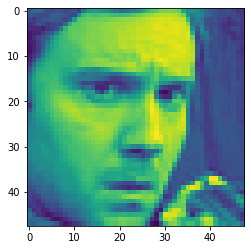

In [5]:
pixel_cnn_augment = create_my_cnn(Xtrain[0].shape, ytrain_ohe[0].shape[0], 'softmax')
Xtrain_augment = augment_data(Xtrain, ytrain_ohe, (48, 48))

pixel_cnn_augment.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pixel_cnn_augment.fit(Xtrain_augment, ytrain_ohe, epochs=30, batch_size=128, verbose=1, validation_data=(Xval, yval_ohe))
pixel_cnn_augment.save('Models/pixel_cnn_augment')

898/898 [==============================] - 1s 924us/step
<class 'numpy.ndarray'>
Training accuracy: 
83.77512278379602%
Training error: 
16.224877216203982%
113/113 [==============================] - 0s 938us/step
Validation accuracy: 
49.90247979938702%
Validation error: 
50.097520200612976%
113/113 [==============================] - 0s 997us/step
Test accuracy: 
49.31735859570911%
Test error: 
50.682641404290884%
Average precision: 60.998320392964054%


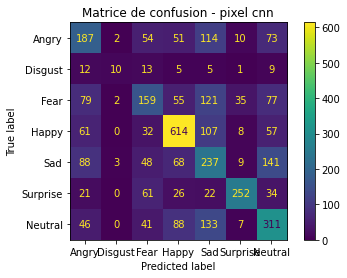

898/898 [==============================] - 1s 916us/step
<class 'numpy.ndarray'>
Training accuracy: 
92.58420704308753%
Training error: 
7.415792956912471%
113/113 [==============================] - 0s 984us/step
Validation accuracy: 
47.199777096684315%
Validation error: 
52.800222903315685%
113/113 [==============================] - 0s 952us/step
Test accuracy: 
48.11925327389245%
Test error: 
51.88074672610755%
Average precision: 62.63441247122144%


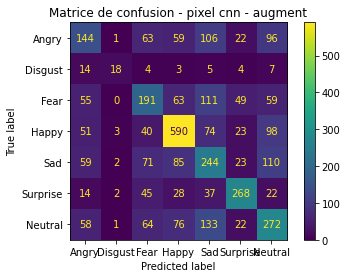

In [6]:
eval_model(pixel_cnn, Xtrain, ytrain, Xtest, ytest, Xval, yval, 'pixel cnn')
eval_model(pixel_cnn_augment, Xtrain, ytrain, Xtest, ytest, Xval, yval, 'pixel cnn - augment')

#### Résultats et réponses:
Vos résultats ici

| Ensemble | My CNN   | My CNN - Augmentation   |
|----------|----------|-------------------------|
| App      | 83.78%   |                  92.58% |
| Val      | 49.90%   |                  47.20% |
| Test     | 50.10%   |                  48.12% |
| Moyenne  | 61.00%   |                  62.63% |

### 3b: Code CNN Pré-entraîné (FER)

##### À faire:
1. Récupérer une des architectures [CNN pré-entraînes disponibles dans Keras](https://keras.io/api/applications/) pour faire un "transfert de connaissance" (transfer learning). Faire un "fine-tuning" du modèle choisi sur FER.    
2. Entraîner et optimiser les paramètres du réseau.
3. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.

##### Sans augmentation:

In [5]:
Xtrain_rgb, Xval_rgb, Xtest_rgb = convert_to_rgb(Xtrain, Xval, Xtest, 48, 48)

In [102]:

pretrained_resnet50 = ResNet50(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

resnet50 = transfer_train(pretrained_resnet50, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
resnet50.save("Models/resnet50")

Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 1.6520 - accuracy: 0.3743

2022-07-04 15:29:50.950276: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.950319: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.964561: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-04 15:29:50.964587: W tensorflow/core/common_runtime/bfc_allocato

225/225 [==============================] - 9s 30ms/step - loss: 1.6520 - accuracy: 0.3743 - val_loss: 1.5402 - val_accuracy: 0.4037
Epoch 2/30
225/225 [==============================] - 6s 26ms/step - loss: 1.4817 - accuracy: 0.4305 - val_loss: 1.4965 - val_accuracy: 0.4205
Epoch 3/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4114 - accuracy: 0.4607 - val_loss: 1.4814 - val_accuracy: 0.4335
Epoch 4/30
225/225 [==============================] - 6s 25ms/step - loss: 1.3558 - accuracy: 0.4854 - val_loss: 1.4574 - val_accuracy: 0.4436
Epoch 5/30
225/225 [==============================] - 6s 26ms/step - loss: 1.3056 - accuracy: 0.5088 - val_loss: 1.4627 - val_accuracy: 0.4436
Epoch 6/30
225/225 [==============================] - 6s 26ms/step - loss: 1.2558 - accuracy: 0.5278 - val_loss: 1.4587 - val_accuracy: 0.4525
Epoch 7/30
225/225 [==============================] - 6s 26ms/step - loss: 1.2125 - accuracy: 0.5454 - val_loss: 1.4843 - val_accuracy: 0.4519
Epoch 8/30

INFO:tensorflow:Assets written to: Models/resnet50/assets


INFO:tensorflow:Assets written to: Models/resnet50/assets


In [103]:
pretrained_mobilenet = MobileNetV2(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

mobilenet = transfer_train(pretrained_mobilenet, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
mobilenet.save("Models/mobilenet")

Epoch 1/30
225/225 [==============================] - 6s 18ms/step - loss: 1.8030 - accuracy: 0.2626 - val_loss: 1.7505 - val_accuracy: 0.2867
Epoch 2/30
225/225 [==============================] - 3s 14ms/step - loss: 1.7156 - accuracy: 0.3032 - val_loss: 1.7364 - val_accuracy: 0.2948
Epoch 3/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6898 - accuracy: 0.3190 - val_loss: 1.7359 - val_accuracy: 0.2926
Epoch 4/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6671 - accuracy: 0.3284 - val_loss: 1.7193 - val_accuracy: 0.3051
Epoch 5/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6522 - accuracy: 0.3403 - val_loss: 1.7265 - val_accuracy: 0.2895
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6364 - accuracy: 0.3457 - val_loss: 1.7203 - val_accuracy: 0.3012
Epoch 7/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6206 - accuracy: 0.3559 - val_loss: 1.7142 - val_accuracy: 0.3090

INFO:tensorflow:Assets written to: Models/mobilenet/assets


INFO:tensorflow:Assets written to: Models/mobilenet/assets


In [104]:
pretrained_vgg19 = VGG19(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

vgg19 = transfer_train(pretrained_vgg19, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
vgg19.save('Models/vgg19')

Epoch 1/30
225/225 [==============================] - 9s 37ms/step - loss: 5.4351 - accuracy: 0.2818 - val_loss: 2.8940 - val_accuracy: 0.3215
Epoch 2/30
225/225 [==============================] - 8s 34ms/step - loss: 2.3393 - accuracy: 0.3482 - val_loss: 2.2685 - val_accuracy: 0.3458
Epoch 3/30
225/225 [==============================] - 8s 34ms/step - loss: 1.8228 - accuracy: 0.3842 - val_loss: 1.9062 - val_accuracy: 0.3711
Epoch 4/30
225/225 [==============================] - 8s 34ms/step - loss: 1.6115 - accuracy: 0.4184 - val_loss: 1.7977 - val_accuracy: 0.3728
Epoch 5/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4996 - accuracy: 0.4471 - val_loss: 1.7746 - val_accuracy: 0.3926
Epoch 6/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4342 - accuracy: 0.4637 - val_loss: 1.7441 - val_accuracy: 0.3709
Epoch 7/30
225/225 [==============================] - 8s 34ms/step - loss: 1.3743 - accuracy: 0.4835 - val_loss: 1.7312 - val_accuracy: 0.3842

INFO:tensorflow:Assets written to: Models/vgg19/assets


INFO:tensorflow:Assets written to: Models/vgg19/assets


In [105]:
pretrained_EfficientNetV2L= EfficientNetV2L(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

efficientNetV2L = transfer_train(pretrained_vgg19, Xtrain_rgb, ytrain_ohe, Xval_rgb, yval_ohe)
efficientNetV2L.save('Models/efficientNet')

Epoch 1/30
225/225 [==============================] - 8s 35ms/step - loss: 5.0372 - accuracy: 0.2759 - val_loss: 2.7334 - val_accuracy: 0.2984
Epoch 2/30
225/225 [==============================] - 8s 35ms/step - loss: 2.1725 - accuracy: 0.3369 - val_loss: 1.9640 - val_accuracy: 0.3458
Epoch 3/30
225/225 [==============================] - 8s 35ms/step - loss: 1.7132 - accuracy: 0.3855 - val_loss: 1.8215 - val_accuracy: 0.3477
Epoch 4/30
225/225 [==============================] - 8s 35ms/step - loss: 1.5548 - accuracy: 0.4190 - val_loss: 1.6909 - val_accuracy: 0.3728
Epoch 5/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4632 - accuracy: 0.4485 - val_loss: 1.6725 - val_accuracy: 0.3892
Epoch 6/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4095 - accuracy: 0.4641 - val_loss: 1.6554 - val_accuracy: 0.3929
Epoch 7/30
225/225 [==============================] - 8s 35ms/step - loss: 1.3678 - accuracy: 0.4816 - val_loss: 1.6490 - val_accuracy: 0.3965

INFO:tensorflow:Assets written to: Models/efficientNet/assets


INFO:tensorflow:Assets written to: Models/efficientNet/assets


##### Augmentation:

In [12]:
Xtrain_rgb_augment = augment_data(Xtrain_rgb, ytrain_ohe, (48, 48))

2022-07-04 15:59:39.061469: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1587492864 exceeds 10% of free system memory.
2022-07-04 15:59:39.713533: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1587492864 exceeds 10% of free system memory.


In [13]:
pretrained_resnet50 = ResNet50(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

resnet50 = transfer_train(pretrained_resnet50, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
resnet50.save("Models/resnet50_augment")

Epoch 1/30


2022-07-04 15:59:50.049053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


225/225 [==============================] - 10s 30ms/step - loss: 1.6354 - accuracy: 0.3769 - val_loss: 1.5242 - val_accuracy: 0.4037
Epoch 2/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4766 - accuracy: 0.4352 - val_loss: 1.5119 - val_accuracy: 0.4168
Epoch 3/30
225/225 [==============================] - 6s 25ms/step - loss: 1.4122 - accuracy: 0.4628 - val_loss: 1.4839 - val_accuracy: 0.4344
Epoch 4/30
225/225 [==============================] - 6s 26ms/step - loss: 1.3614 - accuracy: 0.4805 - val_loss: 1.4542 - val_accuracy: 0.4397
Epoch 5/30
225/225 [==============================] - 6s 25ms/step - loss: 1.3169 - accuracy: 0.5021 - val_loss: 1.4791 - val_accuracy: 0.4377
Epoch 6/30
225/225 [==============================] - 6s 25ms/step - loss: 1.2686 - accuracy: 0.5205 - val_loss: 1.4571 - val_accuracy: 0.4592
Epoch 7/30
225/225 [==============================] - 6s 25ms/step - loss: 1.2232 - accuracy: 0.5397 - val_loss: 1.4592 - val_accuracy: 0.4539
Epoch 8/3

INFO:tensorflow:Assets written to: Models/resnet50_augment/assets


INFO:tensorflow:Assets written to: Models/resnet50_augment/assets


In [14]:
pretrained_mobilenet = MobileNetV2(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

mobilenet = transfer_train(pretrained_mobilenet, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
mobilenet.save("Models/mobilenet_augment")

Epoch 1/30
225/225 [==============================] - 6s 19ms/step - loss: 1.7950 - accuracy: 0.2676 - val_loss: 1.7637 - val_accuracy: 0.2731
Epoch 2/30
225/225 [==============================] - 3s 14ms/step - loss: 1.7208 - accuracy: 0.2993 - val_loss: 1.7394 - val_accuracy: 0.2967
Epoch 3/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6962 - accuracy: 0.3142 - val_loss: 1.7481 - val_accuracy: 0.2906
Epoch 4/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6701 - accuracy: 0.3318 - val_loss: 1.7206 - val_accuracy: 0.3098
Epoch 5/30
225/225 [==============================] - 4s 16ms/step - loss: 1.6569 - accuracy: 0.3374 - val_loss: 1.7127 - val_accuracy: 0.3040
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 1.6397 - accuracy: 0.3456 - val_loss: 1.7217 - val_accuracy: 0.3076
Epoch 7/30
225/225 [==============================] - 3s 14ms/step - loss: 1.6282 - accuracy: 0.3493 - val_loss: 1.7191 - val_accuracy: 0.3118

INFO:tensorflow:Assets written to: Models/mobilenet_augment/assets


INFO:tensorflow:Assets written to: Models/mobilenet_augment/assets


In [15]:
pretrained_vgg19 = VGG19(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

vgg19 = transfer_train(pretrained_vgg19, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
vgg19.save('Models/vgg19_augment')

Epoch 1/30
225/225 [==============================] - 10s 37ms/step - loss: 4.5895 - accuracy: 0.2850 - val_loss: 2.4050 - val_accuracy: 0.3132
Epoch 2/30
225/225 [==============================] - 8s 34ms/step - loss: 1.9717 - accuracy: 0.3329 - val_loss: 1.8411 - val_accuracy: 0.3344
Epoch 3/30
225/225 [==============================] - 8s 34ms/step - loss: 1.6660 - accuracy: 0.3786 - val_loss: 1.7102 - val_accuracy: 0.3628
Epoch 4/30
225/225 [==============================] - 8s 35ms/step - loss: 1.5441 - accuracy: 0.4148 - val_loss: 1.6619 - val_accuracy: 0.3798
Epoch 5/30
225/225 [==============================] - 8s 34ms/step - loss: 1.4775 - accuracy: 0.4341 - val_loss: 1.6334 - val_accuracy: 0.3873
Epoch 6/30
225/225 [==============================] - 8s 35ms/step - loss: 1.4221 - accuracy: 0.4565 - val_loss: 1.6266 - val_accuracy: 0.3926
Epoch 7/30
225/225 [==============================] - 8s 35ms/step - loss: 1.3814 - accuracy: 0.4738 - val_loss: 1.6493 - val_accuracy: 0.402

INFO:tensorflow:Assets written to: Models/vgg19_augment/assets


INFO:tensorflow:Assets written to: Models/vgg19_augment/assets


In [16]:
pretrained_EfficientNetV2L= EfficientNetV2L(include_top=False,
                               input_shape=(48,48,3),
                               pooling='avg',classes=len(labels),
                               weights='imagenet')

efficientNetV2L = transfer_train(pretrained_vgg19, Xtrain_rgb_augment, ytrain_ohe, Xval_rgb, yval_ohe)
efficientNetV2L.save('Models/efficientNet_augment')

Epoch 1/30
225/225 [==============================] - 9s 37ms/step - loss: 4.4709 - accuracy: 0.2754 - val_loss: 2.2667 - val_accuracy: 0.3015
Epoch 2/30
225/225 [==============================] - 8s 36ms/step - loss: 1.8805 - accuracy: 0.3361 - val_loss: 1.7668 - val_accuracy: 0.3380
Epoch 3/30
225/225 [==============================] - 8s 36ms/step - loss: 1.6225 - accuracy: 0.3793 - val_loss: 1.6801 - val_accuracy: 0.3625
Epoch 4/30
225/225 [==============================] - 8s 36ms/step - loss: 1.5261 - accuracy: 0.4134 - val_loss: 1.6622 - val_accuracy: 0.3789
Epoch 5/30
225/225 [==============================] - 8s 36ms/step - loss: 1.4654 - accuracy: 0.4366 - val_loss: 1.6278 - val_accuracy: 0.3884
Epoch 6/30
225/225 [==============================] - 8s 36ms/step - loss: 1.4205 - accuracy: 0.4534 - val_loss: 1.6326 - val_accuracy: 0.3870
Epoch 7/30
225/225 [==============================] - 8s 36ms/step - loss: 1.3830 - accuracy: 0.4725 - val_loss: 1.6453 - val_accuracy: 0.3901

INFO:tensorflow:Assets written to: Models/efficientNet_augment/assets


INFO:tensorflow:Assets written to: Models/efficientNet_augment/assets


#### Résultats et réponses:

898/898 [==============================] - 11s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
86.47810791041137%
Training error: 
13.521892089588627%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
44.608526051825024%
Validation error: 
55.39147394817498%
113/113 [==============================] - 1s 10ms/step
Test accuracy: 
45.416550571189745%
Test error: 
54.58344942881026%
Average precision: 58.834394844475376%


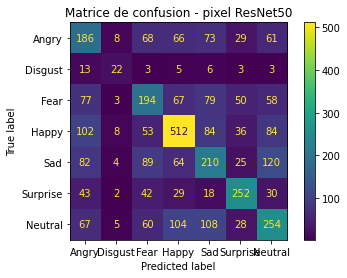

898/898 [==============================] - 7s 7ms/step
<class 'numpy.ndarray'>
Training accuracy: 
53.16102964227246%
Training error: 
46.83897035772754%
113/113 [==============================] - 1s 6ms/step
Validation accuracy: 
31.262190025076624%
Validation error: 
68.73780997492338%
113/113 [==============================] - 1s 6ms/step
Test accuracy: 
30.927835051546392%
Test error: 
69.0721649484536%
Average precision: 38.45035157296516%


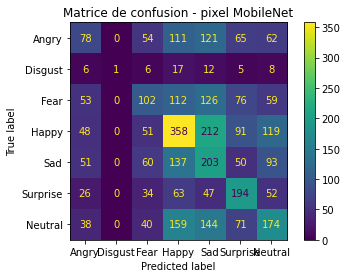

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
69.10724859800062%
Training error: 
30.892751401999373%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.06687099470604%
Validation error: 
59.93312900529395%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
42.57453329618278%
Test error: 
57.42546670381722%
Average precision: 50.582884296296484%


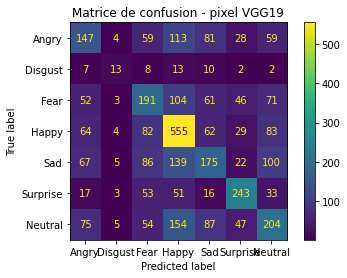

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
68.8564561635724%
Training error: 
31.1435438364276%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
38.86876567288938%
Validation error: 
61.13123432711062%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
41.543605461131236%
Test error: 
58.45639453886877%
Average precision: 49.75627576586434%


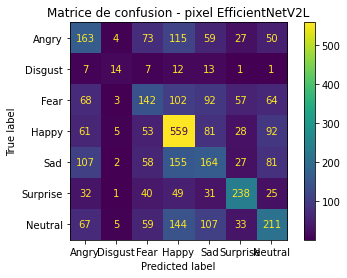

In [17]:
resnet50 = keras.models.load_model("Models/resnet50")
mobilenet = keras.models.load_model("Models/mobilenet")
vgg19 = keras.models.load_model('Models/vgg19')
efficientNetV2L = keras.models.load_model('Models/efficientNet')

eval_model(resnet50, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel ResNet50')
eval_model(mobilenet, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel MobileNet')
eval_model(vgg19, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel VGG19')
eval_model(efficientNetV2L, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel EfficientNetV2L')

2022-07-04 16:29:55.834405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


898/898 [==============================] - 12s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
84.61806402173534%
Training error: 
15.38193597826466%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
44.71997770966843%
Validation error: 
55.28002229033157%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
44.9707439398161%
Test error: 
55.0292560601839%
Average precision: 58.1029285570733%


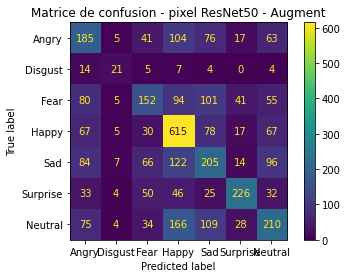

898/898 [==============================] - 7s 7ms/step
<class 'numpy.ndarray'>
Training accuracy: 
51.31143543836427%
Training error: 
48.68856456163573%
113/113 [==============================] - 1s 6ms/step
Validation accuracy: 
31.707996656450266%
Validation error: 
68.29200334354974%
113/113 [==============================] - 1s 6ms/step
Test accuracy: 
30.760657564781273%
Test error: 
69.23934243521872%
Average precision: 37.9266965531986%


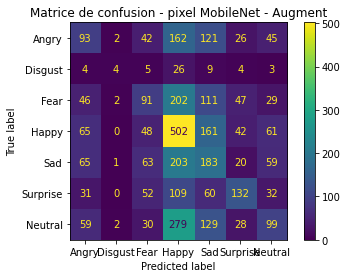

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
68.28172350134103%
Training error: 
31.71827649865896%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.26191139593202%
Validation error: 
59.73808860406798%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
40.65199219838395%
Test error: 
59.34800780161604%
Average precision: 49.73187569855234%


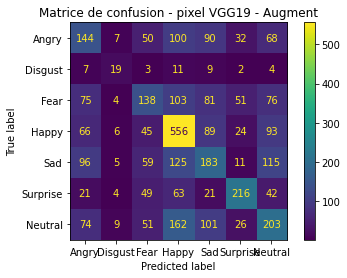

898/898 [==============================] - 10s 11ms/step
<class 'numpy.ndarray'>
Training accuracy: 
67.56766170887178%
Training error: 
32.43233829112822%
113/113 [==============================] - 1s 11ms/step
Validation accuracy: 
40.401225968236275%
Validation error: 
59.598774031763725%
113/113 [==============================] - 1s 11ms/step
Test accuracy: 
40.568403455001395%
Test error: 
59.43159654499861%
Average precision: 49.51243037736982%


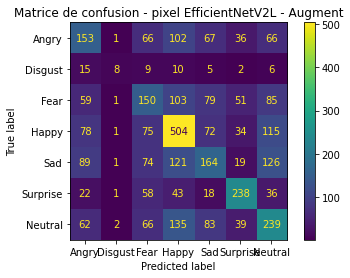

In [6]:
resnet50_augment = keras.models.load_model("Models/resnet50_augment")
mobilenet_augment = keras.models.load_model("Models/mobilenet_augment")
vgg19_augment = keras.models.load_model('Models/vgg19_augment')
efficientNetV2L_augment = keras.models.load_model('Models/efficientNet_augment')

eval_model(resnet50_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel ResNet50 - Augment')
eval_model(mobilenet_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel MobileNet - Augment')
eval_model(vgg19_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel VGG19 - Augment')
eval_model(efficientNetV2L_augment, Xtrain_rgb, ytrain, Xtest_rgb, ytest, Xval_rgb, yval, 'pixel EfficientNetV2L - Augment')

#### Sans Augmentation
| Ensemble | My CNN   | Resnet50   | MobileNet | VGG 19 | EfficientNetV2L |
|----------|----------|------------|-----------|--------|-----------------|
| App      | 83.78%   |     80.32% |    47.29% | 62.84% |          65.58% |
| Val      | 49.90%   |     43.69% |    30.29% | 37.16% |          39.45% |
| Test     | 50.10%   |     45.33% |    29.73% | 39.12% |          39.98% |
| Moyenne  | 61.00%   |     56.45% |    35.77% | 47.06% |          48.34% |

#### Augmentation
| Ensemble | My CNN   | Resnet50   | MobileNet | VGG 19 | EfficientNetV2L |
|----------|----------|------------|-----------|--------|-----------------|
| App      | 92.58%   |     84.62% |    51.31% | 68.28% |          67.57% |
| Val      | 47.20%   |     44.72% |    31.71% | 40.26% |          40.40% |
| Test     | 48.12%   |     44.97% |    30.76% | 40.65% |          40.57% |
| Moyenne  | 62.63%   |     58.10% |    37.93% | 49.73% |          49.51% |

### 3c: Code CNN Pré-entraîné (FG-NET):

##### À faire:
1. Choisir le modèle \ l’architecture qu’a donné de meilleurs résultats sur FER pour faire un “transfert de connaissance (transfer learning).
2. Adapter ce modèle pour FG-NET (couche de sortie classification (7 unités avec softmax) -> régression (1 unité lineaire)).   
3. Entraîner ("fine-tuning" du modèle choisi sur FG-NET) et optimiser les paramètres du réseau pour la régression.
4. Évaluer la pertinence d’utiliser "data augmentation" pour améliorer la généralisation.
5. Faire une analyse des résultats et présenter vos conclusions sur les réseaux de neurones.

In [17]:
X_fgnet = np.loadtxt('Datasets/fgnet_256x256.csv', delimiter=',', dtype=int )
y_fgnet = np.loadtxt('Datasets/fgnet_labels.csv', delimiter=',', dtype=int )

X_fgnet = X_fgnet.reshape(X_fgnet.shape[0], 256, 256, 1)
X_fgnet = pretreat_fgnet(X_fgnet)

Xtrain_fgnet, Xtest_fgnet, ytrain_fgnet, ytest_fgnet = sklearn.model_selection.train_test_split(X_fgnet, y_fgnet, test_size=0.2, random_state=1)
Xtrain_fgnet, Xval_fgnet, ytrain_fgnet, yval_fgnet = sklearn.model_selection.train_test_split(Xtrain_fgnet, ytrain_fgnet, test_size=0.25, random_state=1)

Xtrain_fgnet_augment = augment_data(Xtrain_fgnet, ytrain_fgnet, (48, 48))

In [24]:
# Nos meilleurs résultats ont été observés avec le modèle My CNN sans augmentation
pixel_cnn_fg: Sequential = keras.models.load_model('Models/pixel_cnn')
pixel_cnn_fg.pop()
for layer in pixel_cnn_fg.layers:
      layer.trainable = False
pixel_cnn_fg.add(Dense(1, activation='linear', name='Dense3'))

# Training
pixel_cnn_fg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['MSE'])
pixel_cnn_fg.fit(Xtrain_fgnet, ytrain_fgnet, epochs=60, batch_size=128, verbose=1, validation_split=0.2)
pixel_cnn_fg.save('Models/pixel_cnn_fg')

600
Epoch 1/60
4/4 [==============================] - 0s 37ms/step - loss: 1.8070e-06 - MSE: 397.2765 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 2/60
4/4 [==============================] - 0s 7ms/step - loss: 1.8070e-06 - MSE: 396.3695 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 3/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 396.3260 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 4/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 396.9670 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 5/60
4/4 [==============================] - 0s 10ms/step - loss: 1.8070e-06 - MSE: 397.7168 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 6/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 396.3313 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 7/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 396.5075 - val_loss: 2.0156e-06 - val_MSE: 478.4286
Epoch 8/60
4/4

INFO:tensorflow:Assets written to: Models/pixel_cnn_fg/assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_fg/assets


In [27]:
#"pixel"
# Create the model
pixel_cnn_fg_augment: Sequential = keras.models.load_model('Models/pixel_cnn')
pixel_cnn_fg_augment.pop()
for layer in pixel_cnn_fg_augment.layers:
      layer.trainable = False
pixel_cnn_fg_augment.add(Dense(1, activation='linear'))

# Training
pixel_cnn_fg_augment.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['MSE'])
pixel_cnn_fg_augment.fit(Xtrain_fgnet_augment, ytrain_fgnet, epochs=60, batch_size=128, verbose=1, validation_split=0.2)
pixel_cnn_fg_augment.save('Models/pixel_cnn_fg_augment')

Epoch 1/60
4/4 [==============================] - 0s 39ms/step - loss: 1.8070e-06 - MSE: 401.0703 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 2/60
4/4 [==============================] - 0s 8ms/step - loss: 1.8070e-06 - MSE: 400.3546 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 3/60
4/4 [==============================] - 0s 8ms/step - loss: 1.8070e-06 - MSE: 400.7461 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 4/60
4/4 [==============================] - 0s 8ms/step - loss: 1.8070e-06 - MSE: 399.1765 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 5/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 399.7865 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 6/60
4/4 [==============================] - 0s 9ms/step - loss: 1.8070e-06 - MSE: 399.6227 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 7/60
4/4 [==============================] - 0s 8ms/step - loss: 1.8070e-06 - MSE: 400.1476 - val_loss: 2.0156e-06 - val_MSE: 483.4001
Epoch 8/60
4/4 [===

INFO:tensorflow:Assets written to: Models/pixel_cnn_fg_augment/assets


INFO:tensorflow:Assets written to: Models/pixel_cnn_fg_augment/assets


In [33]:
pixel_cnn_fg = keras.models.load_model("Models/pixel_cnn_fg")

eval_regression_model(pixel_cnn_fg, Xtrain_fgnet, ytrain_fgnet, Xtest_fgnet, ytest_fgnet, Xval_fgnet, yval_fgnet, 'pixel CNN')

7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343
7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343


#### Résultats et réponses:

In [34]:
pixel_cnn_fg_augment = keras.models.load_model("Models/pixel_cnn_fg_augment")
eval_regression_model(pixel_cnn_fg_augment, Xtrain_fgnet, ytrain_fgnet, Xtest_fgnet, ytest_fgnet, Xval_fgnet, yval_fgnet, 'pixel CNN - Augment')


7/7 [==============================] - 0s 1ms/step
Training Set
MAE: 15.508333333333333
MSE: 404.5416666666667
R2: -1.4662172603033174
Validation Set
MAE: 16.149253731343283
MSE: 429.2437810945274
R2: -1.548266793155162
Test Set
MAE: 16.52238805970149
MSE: 438.5422885572139
R2: -1.6489543404760343


##### My CNN - Sans augmentation:
| Ensemble | MAE      | MSE           | R2     |
|----------|----------|---------------|--------|
| App      | 15.51    |     404.54    | -1.47  |
| Val      | 16.15    |     429.24    | -1.55  |
| Test     | 16.52    |     438.54    | -1.65  |

##### My CNN - Avec augmentation:
| Ensemble | MAE      | MSE           | R2     |
|----------|----------|---------------|--------|
| App      | 15.51    |     404.54    | -1.47  |
| Val      | 16.15    |     429.24    | -1.55  |
| Test     | 16.52    |     438.54    | -1.65  |

## Partie Final: Conclusion

##### À faire:
1. Résumer et comparer les principaux résultats obtenus pour la classification (FER) et régression (FG-NET).
2. Faire une analyse des résultats obtenus et présenter vos conclusions sur les différents modèles que vous avez entraînés (classification et régression).
3. Comparer les résultats obtenus sur FER avec les résultats du laboratoire 1 (vecteur de pixels, vecteur de primitives). Avez-vous observé une amélioration? Commenter sur les temps d'apprentissage, complexité spatiale et temporelle, etc.

#### Résultats et réponses:
Vos résultats ici

| Algorithme            | MSE           |
|-----------------------|---------------|
| Regr lineaire         | XXX.XX        |
| Regr Ridge            | XXX.XX        |
| Regr Lasso            | XXX.XX        |
| Regr ElasticNet       | XXX.XX        |
| ...                   | XXX.XX        |
| ...                   | XXX.XX        |